# Creating the Model Bathymetry 

## Megan Sharkey

In this notebook, I create the model bathymetry for my model of Nuup Kangerlua. This notebook reads in the GEBCO 2025 file. Using my model grid, I then generate the bathymetry file for my model.

First, import packages to re-create and visualize the model grid here:

In [4]:
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import netCDF4 as nc4

### Bathymetry Source File
To generate the bathymetry for the model, first obtain a subset of the global GEBCO bathymetry grid from here: https://download.gebco.net/


### Interpolating Bathymetry onto the Model Domain
Next, I use an interpolation function to interpolate the GEBCO Bathymetry onto the domain of my model.

In [5]:
# read in the bathymetry grid
file_path = '/Users/msharkey/Documents/MLML/FALL 2025/MS 274/lectures/week 8/GEBCO/gebco_2025_n64.878_s63.8_w-52.8_e-49.205.nc'
ds = nc4.Dataset(file_path)
gebco_lon = ds.variables['lon'][:]
gebco_lat = ds.variables['lat'][:]
Gebco_bathy = ds.variables['elevation'][:]
ds.close()

# create a meshgrid of the lon and lat
Gebco_Lon, Gebco_Lat = np.meshgrid(gebco_lon, gebco_lat)

In [6]:
# recreate the model grid - see previous notebook on creating the model grid for details
# define the parameters that will be used in the data file
XC = np.fromfile('/Users/msharkey/Documents/MLML/FALL 2025/MS 274/lectures/week 8/my_model/XC720_540.bin', '>f8').reshape(720, 1)
#print(XC)
YC = np.fromfile('/Users/msharkey/Documents/MLML/FALL 2025/MS 274/lectures/week 8/my_model/YC720_540.bin', '>f8').reshape(540, 1)
#print(YC)
delX = 3.595/720
delY = 1.078/540
xgOrigin = -52.8
ygOrigin = 63.8
n_rows = 540
n_cols = 720

# recreate the grids that will be used in the model
xc = np.arange(xgOrigin+delX/2, xgOrigin+n_cols*delX+delX/2, delX)
yc = np.arange(ygOrigin+delY/2, ygOrigin+n_rows*delY+delY/2, delY)
XC, YC = np.meshgrid(xc, yc)
print('Double check shape:', np.shape(xc),np.shape(yc))

Double check shape: (720,) (540,)


In [7]:
# interpolate the gebco data onto the model grid
Model_bathy = griddata(np.column_stack([Gebco_Lon.ravel(),Gebco_Lat.ravel()]), Gebco_bathy.ravel(), (XC, YC), method='nearest')

In [8]:
# set points on land to 0
Model_bathy[Model_bathy>0] = 0

### Visualizing the Bathymetry Grid
Finally, I create a plot of the bathymetry and compare with the source data to ensure everything turns out as expected:

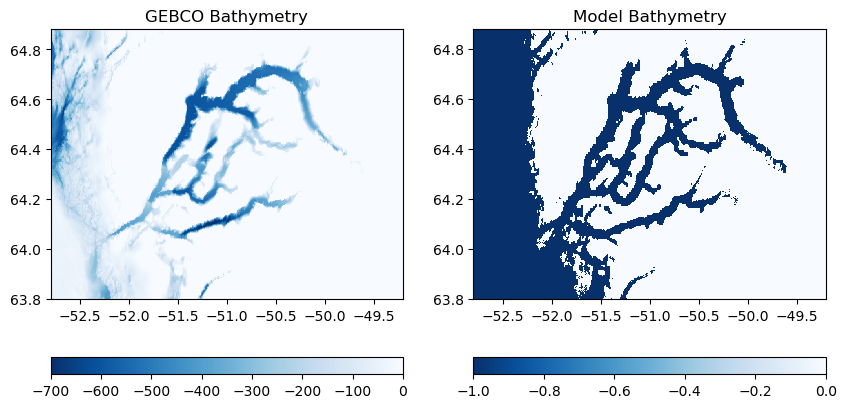

In [9]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
C = plt.pcolormesh(Gebco_Lon, Gebco_Lat, Gebco_bathy, vmin=-700, vmax=0, cmap='Blues_r')
plt.colorbar(C, orientation = 'horizontal')
plt.title('GEBCO Bathymetry')

plt.subplot(1,2,2)
C = plt.pcolormesh(XC, YC, Model_bathy, vmin=-1, vmax=0, cmap='Blues_r')
plt.colorbar(C, orientation = 'horizontal')
plt.title('Model Bathymetry')

plt.show()

### Checking for isolated regions
One potential problem that can be encountered in ocean models occurs with isolated regions

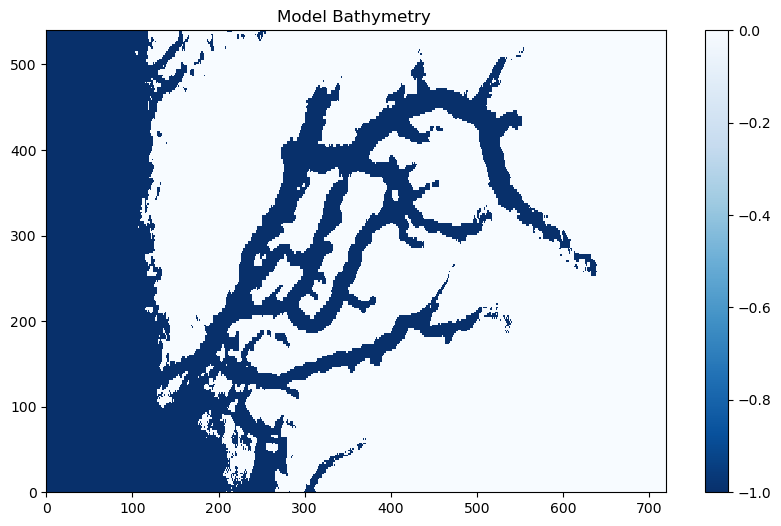

In [10]:
plt.figure(figsize=(10,6))

C = plt.pcolormesh(Model_bathy, vmin=-1, vmax=0, cmap='Blues_r')
plt.colorbar(C)
plt.title('Model Bathymetry ')

plt.show()

In [11]:
from eccoseas.downscale import bathymetry as edb

With the tools imported, we can now use the `fill_unconnected_model_regions` to fill in these regions.

In [12]:
Model_bathy = edb.fill_unconnected_model_regions(Model_bathy, central_wet_row=100, central_wet_col=100)

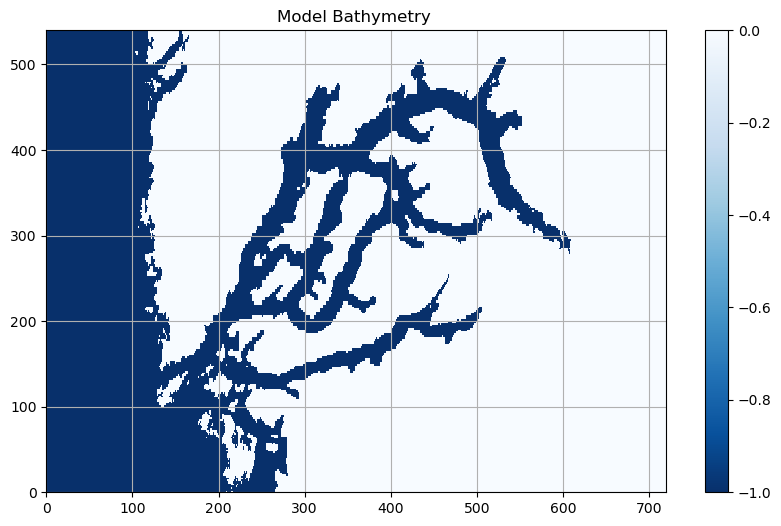

In [13]:
plt.figure(figsize=(10,6))

C = plt.pcolormesh(Model_bathy, vmin=-1, vmax=0, cmap='Blues_r')
plt.colorbar(C)
plt.grid()
plt.title('Model Bathymetry ')

plt.show()

### Checking for problem areas
Another potential problem that can be encountered in ocean models occurs in regions where there is shallow bathymetry in enclosed bays. In these regions, there can be fast currents and strong dynamics. If this is your area of interest, then this is great! If not, it may cause problems in your domain. One option is to manually fill in these areas to avoid any potential issues. 

In this example, I will fill in the Juan de Fuca Strait between Canada and Washington State.

In [14]:
# fill in some areas around BC
Model_bathy_filled = np.copy(Model_bathy)
Model_bathy_filled[400:500, 100:200] = 0
Model_bathy_filled[500:600, 100:200] = 0
Model_bathy_filled[275:286, 605:610] = 0
# to make the virtual mooring points:
# Model_bathy_filled[x,y] = 1 
# Model_bathy_filled[x,y] = 2 
# and so on 

# fill in the right boundary
Model_bathy_filled[:,-1]=0
Model_bathy_filled[:,-2]=0

Then, plot the filled bathymetry to ensure it looks as expected.  I ran into an issue with a section of my bathymetry around the (605, 275) grid that I needed to fill in. 

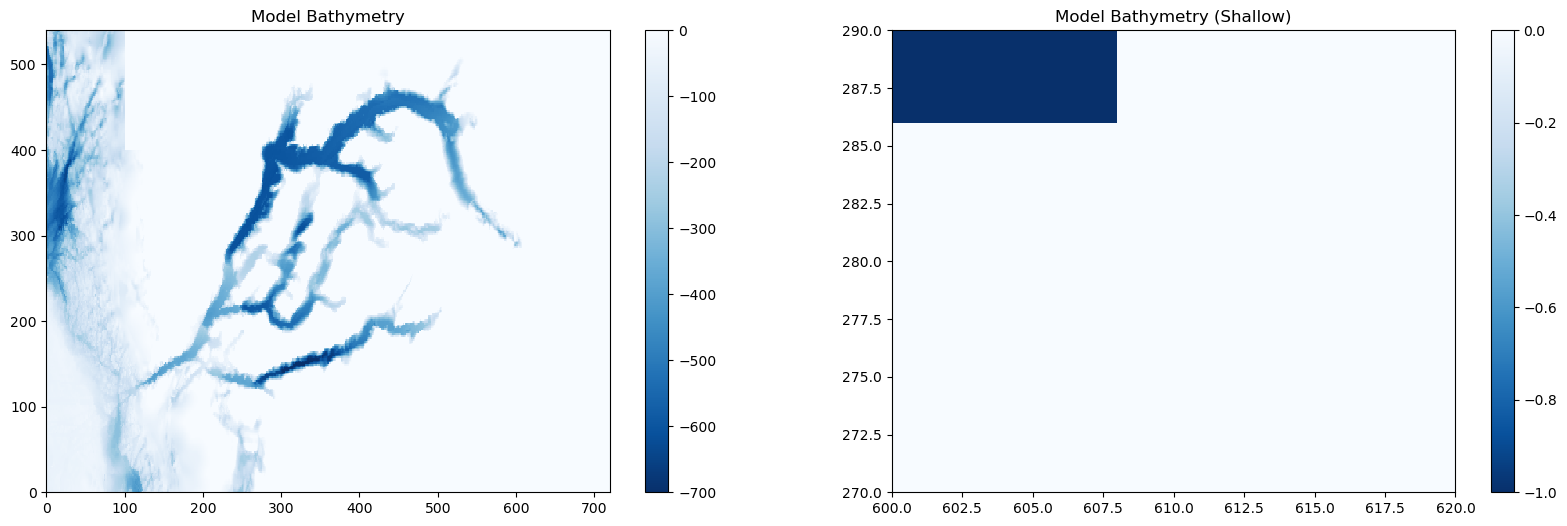

In [17]:
plt.figure(figsize=(20,6))

plt.subplot(1,2,1)
C = plt.pcolormesh(Model_bathy_filled, vmin=-700, vmax=0, cmap='Blues_r')
plt.colorbar(C)
plt.title('Model Bathymetry')

plt.subplot(1,2,2)
C = plt.pcolormesh(Model_bathy_filled, vmin=-1, vmax=0, cmap='Blues_r')
plt.colorbar(C)
plt.title('Model Bathymetry (Shallow)')
plt.xlim([600,620])
plt.ylim([270,290])
#plt.plot(609,282, 'r.')

plt.show()

In [18]:
output_file = 'Greenland_bathymetry_filled.bin'
Model_bathy_filled.ravel('C').astype('>f4').tofile(output_file)

This will be implemented into the model by editing the `PARM05` dataset of the `data` file as follows:
```
 &PARM05
 bathyFile = 'CA_bathymetry.bin,
 &
```